In [50]:
import os
import glob
import calendar

import numpy as np
# %load_extcudf.pandas
import pandas as pd
import geopandas as gpd

from shapely.geometry import  mapping #shape, 
import rasterio
# from rasterio.mask import mask
from rasterio.features import geometry_mask
# from contextlib import contextmanager

from osgeo import gdal #, osr, ogr

In [3]:
# @contextmanager
# def open_tiff_file(filepath):
#     with rasterio.open(filepath) as src:
#         array = src.read(1)
#         no_data_value = src.nodata
#         if no_data_value is not None:
#             array = np.where(array == no_data_value, 0, array)
#         yield array
# def get_unit_codes(root_folder):
#     unit_codes = []
#     for subfolder in os.listdir(root_folder):
#         subfolder_path = os.path.join(root_folder, subfolder)
#         if os.path.isdir(subfolder_path):
#             for tiff_file in os.listdir(subfolder_path):
#                 if tiff_file.endswith('.tif'):
#                     unit_codes.append(int(tiff_file[:-4]))
                    
                
#     # return sorted(unit_codes)

# def read_tiff_file(subfolder_path, unit_code):
#     tiff_file = f"{unit_code}.tif"
#     tiff_file_path = os.path.join(subfolder_path, tiff_file)
#     if os.path.exists(tiff_file_path):
#         with open_tiff_file(tiff_file_path) as array:
#             array = np.where(np.logical_or(np.isnan(array), np.isinf(array)), 0, array)
#             return array
#     else:
#         return None


# def read_tiff_file0(tiff_file_path):
#     # tiff_file = f"{unit_code}.tif"
#     # tiff_file_path = os.path.join(subfolder_path, tiff_file)
#     if os.path.exists(tiff_file_path):
#         with open_tiff_file(tiff_file_path) as array:
#             array = np.where(np.logical_or(np.isnan(array), np.isinf(array)), 0, array)
#             return array
#     else:
#         return None

def createList(r1, r2):
    # Create a list of the months betweeen planting and maturity
    return np.arange(r1, r2+1)

def getListcom(p, m):
    # check if planting and maturity are in the same year
    if np.any(p < m):
        return createList(p, m)
    else:
        return np.concatenate((createList(p, 12), createList(1, m)))

In [4]:
# cCropCal = pd.read_csv("step1/hypothetical_ccc3.csv")
cCropCal = pd.read_csv("../data/CropCalender/2000_ir.csv")

cCropCal

,Country,State,District,unit_code,Crop,Subcrop,Type,Growing_area,Planting_Month,Maturity_Month
0,India,Andaman and Nicobar,Nicobar,3560001,Barley,1,Annual,0,7,11
1,India,Andaman and Nicobar,North & Middle Andaman,3560002,Barley,1,Annual,0,7,11
2,India,Andaman and Nicobar,South Andaman,3560003,Barley,1,Annual,0,7,11
3,India,Andhra Pradesh,Adilabad,3560004,Barley,1,Annual,0,7,11
4,India,Andhra Pradesh,Anantapur,3560005,Barley,1,Annual,0,7,11
...,...,...,...,...,...,...,...,...,...,...
16830,India,Uttarakhand,Pithoragarh,3560618,Rice3,3,Annual,1498,12,3
16831,India,Uttarakhand,Rudraprayag,3560619,Rice3,3,Annual,948,12,3
16832,India,Uttarakhand,Tehri Garhwal,3560620,Rice3,3,Annual,3032,12,3
16833,India,Uttarakhand,Udham Singh Nagar,3560621,Rice3,3,Annual,32259,12,3


In [5]:
# rank each by crop area in each unit code
def rank_crops(df_area):
#     print(df_area)
    df_area = df_area.sort_values('Growing_area', ascending=False)
    df_area['rank'] = range(1, len(df_area) + 1)
#     print(df_area)
    return df_area.set_index('rank')
    
ranked_df = cCropCal.sort_values(['unit_code', 'Crop']) \
    .groupby('unit_code') \
    .apply(rank_crops) \
    .reset_index(level=0, drop=True) \
    .reset_index() \
    .sort_values(['unit_code', 'rank'], ignore_index=True)

ranked_df


/tmp/ipykernel_55/1745104835.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rank_crops) \


,rank,Country,State,District,unit_code,Crop,Subcrop,Type,Growing_area,Planting_Month,Maturity_Month
0,1,India,Andaman and Nicobar,Nicobar,3560001,Barley,1,Annual,0,7,11
1,2,India,Andaman and Nicobar,Nicobar,3560001,Cassava,1,Annual,0,11,3
2,3,India,Andaman and Nicobar,Nicobar,3560001,Wheat1,1,Annual,0,12,4
3,4,India,Andaman and Nicobar,Nicobar,3560001,Sunflower,1,Annual,0,7,11
4,5,India,Andaman and Nicobar,Nicobar,3560001,Sugar cane,1,Perennial,0,1,12
...,...,...,...,...,...,...,...,...,...,...,...
16830,22,India,West Bengal,Uttar Dinajpur,3560641,Fodder,1,Fodder,0,1,12
16831,23,India,West Bengal,Uttar Dinajpur,3560641,Cotton,1,Annual,0,10,7
16832,24,India,West Bengal,Uttar Dinajpur,3560641,Coffee,1,Perennial,0,1,12
16833,25,India,West Bengal,Uttar Dinajpur,3560641,Cocoa,1,Perennial,0,1,12


In [6]:
raster_folder = "../data/Ras_shape_out/Rasters"
AEI = '../data/Ras_shape_out/Rasters/AEI/AEI_10.tif'
Area = '../data/Ras_shape_out/Rasters/Area/ara_10.tif'
AH = '../data/Ras_shape_out/Rasters/AH'

# ROOT FOLDER CONTAINS SHOULD CONTAIN CROP SUBFOLDERS WITH CLIPPED AREAS TIFF
root_folder = "data/Clipped_2000"

# Load the unit code files
tiff_files = glob.glob("{}/**/*.tif".format(raster_folder), recursive=True)
tiff_files
# # CLE crop land extent

# Load the unit code files
tiff_files = glob.glob("{}/**/*.nc4".format(raster_folder), recursive=True)
tiff_files

['../data/Ras_shape_out/Rasters/CC/bar_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/bar_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/bea_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/bea_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cas_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cas_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cot_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/cot_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mai_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mai_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mil_ir_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rasters/CC/mil_rf_ggcmi_crop_calendar_phase3_v1.01.nc4',
 '../data/Ras_shape_out/Rast

In [7]:
dataset = gdal.Open("../data/Clipped_2000/AEI_00/3560001.tif", gdal.GA_ReadOnly)

In [8]:
dataset.RasterXSize, dataset.RasterYSize, dataset.RasterCount, dataset.GetRasterBand(1)

(20,
 83,
 1,
 <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fc8d0148a20> >)

In [9]:
raster_band = dataset.GetRasterBand(1)
raster_band.ReadAsArray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
# Load the unit code files
tiff_files = glob.glob("{}/**/*.tif".format(raster_folder), recursive=True)
tiff_files

['../data/Ras_shape_out/Rasters/AEI/AEI_10.tif',
 '../data/Ras_shape_out/Rasters/Area/ara_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Bar_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Cas_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Cot_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Fod_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Gro_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Maz_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Mil_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Olp_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Otha.tif',
 '../data/Ras_shape_out/Rasters/Crops/Otha_00.tif',
 '../data/Ras_shape_out/Rasters/Crops/Pot_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Pul_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Rap_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Ric_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Sorg_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Soy_10.tif',
 '../data/Ras_shape_out/Rasters/Crops/Sub_10.tif',
 '../data/Ras_shape_out/Rasters/Cr

In [11]:
shp_folder = "../data/Ras_shape_out/Shapefiles"
shpfiles = glob.glob("{}/**/*.shp".format(shp_folder), recursive=True)
shpfiles

['../data/Ras_shape_out/Shapefiles/India/gadm41_IND_2.shp']

<Axes: >

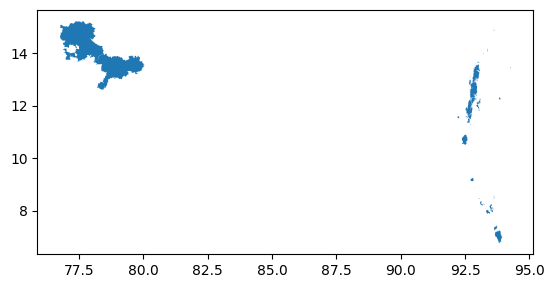

In [12]:
os.listdir(shp_folder)
# gdf = gpd.read_file(shpfiles[0])
gdf = gpd.read_file(shpfiles[0]).iloc[:5]
gdf.plot()

In [13]:
def gdfmask(gdf, raster_path, all_touched=True):
  """ returns a raster mask of the gdf
  
  Parameters
    ----------
    gdf : geopandasdataframe object
        Country
    raster : path to tiff raster
        Administration level

    Returns
    -------
    dictionary of geopandas dataframe's rasters with characteristics of given raster
  
  
  """
  
  with rasterio.open(raster_path) as src:
    # Read the raster data into a NumPy array
    raster_shape = src.read(1).shape
    raster_crs = src.crs
    raster_transform = src.transform

  gdf0 = gdf.to_crs(src.crs)
  gdf_masks = {}
  for index, row in gdf0.iterrows():
    # print(shapely_geometry)
    gdf_masks[index] = geometry_mask([mapping(row['geometry'])],
                                     out_shape=raster_shape,
                                     transform=raster_transform,
                                     all_touched=all_touched, 
                                     invert=True)
  return(gdf_masks)
gdfmask(gdf=gdf, raster_path = AEI)
gdfmask(gdf=gdf, raster_path = Area)

{0: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 1: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 2: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., F

In [14]:
# mask0 = gdfmask(gdf=gdf, raster_path = AEI)
# # mask0 = gdfmask(gdf=gdf, raster_path = Area)
# mask0[0].sum(), mask0[0].shape, mask0[1].sum(), mask0[1].shape

In [15]:
# AEI
# gdal.Open(AEI, gdal.GA_ReadOnly).ReadAsArray()[mask0[3]]

In [16]:
# with rasterio.open(AEI) as src:
#     # Read the raster data into a NumPy array
#     r = AEI*int(mask0[4])


# r

In [17]:
# r[r > 0]

In [18]:
# def open_tiff_file(filepath):
#     with rasterio.open(filepath) as src:
#         array = src.read(1)
#         no_data_value = src.nodata
#         if no_data_value is not None:
#             array = np.where(array == no_data_value, 0, array)
#         yield array

In [19]:
# np.unique(np.array(ranked_df.Crop.tolist()))

In [48]:
def step00(step, ranked_df_rank, dist_array, AH_array, AD_area,
           c_s=None, r_s=None,
           df_mon=None, df_tot = None, TAD_12=None, df_cumulative=None, ATS_2=None, verbose=False,
           template_tiff= None):


    
  p = ranked_df_rank.Planting_Month.tolist()[0]
  m = ranked_df_rank.Maturity_Month.tolist()[0]
  listcom = getListcom(p, m)

  # If step 1
  if step in [1]:
    # CALCULATE AD
    AD_area = np.where(dist_array["dist_array_ara"] > 0,
                      (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_ara"], 0)
    
    # ADJUST AD IF MORE THAN ONE CROP
    if ranked_df_rank.Subcrop.tolist()[0] > 1: 
        AD_area = AD_area/ranked_df_rank.Subcrop.tolist()[0] 


######################################################################


  if step in [2, 3, 4]:
    # Filter the total dataframe for a month in which crop grow
    df_max_filt = df_tot[df_tot["Month"].isin(listcom)]
      
    # Group the cell values
    n = len(df_max_filt) // (r_s * c_s)

    # Select the maximum total area assigned for the month in which this crop grow
    df_max = df_max_filt.groupby(np.arange(len(df_max_filt)) // n).max()
    
    # Change it to array
    max_step2 = np.array(df_max["Total_st1"]).reshape(r_s, c_s)

    
    # Determine the free AEI cell
    AEI_fr_ce_2 = np.where(dist_array["dist_array_aei"] > max_step2, 
                           (dist_array["dist_array_aei"]-max_step2), 0)

    if step in [2]:
      # Determine the AH_free_cell
      AH_fr_ce_2 = np.maximum(AH_array - AD_area, 0)
      
      # Potential area to be distributed in this step
      Pot_ATS2 = np.minimum(AEI_fr_ce_2, AH_fr_ce_2)
        
    if step in [3]:
            
      Pot_ATS2 = np.where(dist_array["dist_array_cle"]>0, AEI_fr_ce_2, 0)
        
    if step in [4]:
            
      Pot_ATS2 = np.where(dist_array["dist_array_cle"] == 0, AEI_fr_ce_2, 0)


    # Determine the distribution ratio as the ratio of ATS and Pot_ATS
    with np.errstate(divide='ignore'):
      AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
    
    # Exact area to be distributed at this step
    if ATS_2>0:
      AD_area2=Pot_ATS2*AD_ra2
      #Area to be distributed in step 1 and 2
                
    else:
      AD_area2=Pot_ATS2*0
      #Area to be distributed in step 1 and 2
      #                 TAD_12=AD_area1

    # TAD_12=AD_area + AD_area2
    AD_area=AD_area + AD_area2




  if step in [1, 2]: #, 2
    if round(np.sum(AD_area),2) <= (ranked_df_rank.Growing_area.tolist()[0]):
    # if round(np.sum(TAD_12),2) < (ranked_df_rank.Growing_area.tolist()[0]):
      ATS_2= (ranked_df_rank.Growing_area.tolist()[0])-round(np.sum(AD_area),2)
      # ATS_3= (ranked_df_rank.Growing_area.tolist()[0])-round(np.sum(TAD_12),2)
      AD_area=AD_area
      # AD_area2=TAD_12
      if verbose:
        print("Area distributed after step {}:".format(step), round(np.sum(AD_area),2))
        print("Iteration continues")
      if round(np.sum(AD_area),2)==(ranked_df_rank.Growing_area.tolist()[0]):
        if verbose:
          print("Area to be distributed in next step (step {}):".format(step+1), ATS_2)
          print("Iteration completed ")
    else:
      ATS_2= 0
      # ATS_3= 0
      if ranked_df_rank.Growing_area.tolist()[0] >0:
        if verbose:
          print("Error check your code!")
          print("More area available than the growing area")
        ratio= ranked_df_rank.Growing_area.tolist()[0]/np.sum(AD_area)
    #                             print(ratio)
        AD_area=AD_area*ratio
        # AD_area2=TAD_12*ratio
          
        if verbose:
          print("Iteration completed")
          print("Area distributed in step {}:".format(step),round( np.sum(AD_area),2))
      if ranked_df_rank.Growing_area.tolist()[0]== 0:
        AD_area=AD_area*0
        # AD_area2=TAD_12*0
        if verbose:
          print("No area will be distributed in step {} (Zero harvested area)".format(step))



  if step in [1, 2, 3, 4]: 
    # Call the array (area) to be distributed monthly
    arr1 = AD_area
    arr1_re = np.repeat(arr1, 12)
    c_s = len(arr1[0])
    r_s = len(arr1)
  
    
  # Call the array to be distributed in step1 and convert it to dataframe
  array_name = "Array_" + ranked_df.Crop.tolist()[0][:3] + ranked_df.Crop.tolist()[0][-1] + "1"
    
  # Create a new dataframe in which we will iterate each cell value for each month according to the crop calendar
  #             crop_sum = 0
  df_month = pd.DataFrame(np.arange(1, 13), columns=['Month'])
  df_mon = pd.concat([df_month] * c_s * r_s, ignore_index=True)
    
  # Change the array to dataframe
  df_1 = pd.DataFrame(arr1_re, index=np.arange(len(df_mon)), columns=[array_name])
  # Merge the month and array dataframe
  df_area1 = pd.concat([df_mon, df_1], axis=1)
  # Filter the month in which the crop grows according to the crop calendar
  crop_1 = df_area1[(df_area1["Month"].isin(listcom))]
  # Filter the month in which the crop didn't grow according to the crop calendar
  crop_not = df_area1[(~df_area1["Month"].isin(listcom))]
  # Set the value of the array to 0 for months when the crop doesn't grow
  crop_not[array_name].values[:] = 0
  # Merge the two dataframes and sort it based on index
  df_name = ranked_df.Crop.tolist()[0][:3] + ranked_df.Crop.tolist()[0][-1] + "_step1"
  df_name = pd.concat([crop_1, crop_not])
  df_name = df_name.sort_index()
#             df_name = np.minimum(df_name, dist_array_aei)

    
  # Assign the area to be distributed in this step for each month according to crop calendar
  df_list = []
  df_list.append(df_name[array_name])

  Step_1 = pd.concat(df_list, axis=1).sum(axis=1)

  if df_cumulative is None:
    df_cumulative = pd.Series(np.zeros(len(Step_1)), index=Step_1.index)
#             if 'df_cumulative_st1' not in locals() or df_cumulative_st1.empty:
#                 df_cumulative_st1 = Step_1.copy()  
#             else:
    
  df_cumulative += Step_1
  if step in [4]:
    df_irrigaed=pd.concat([df_mon, Step_1], axis=1)
    df_irrigaed.columns = ['Month', 'Total_st1']
    
  df_tot = pd.concat([df_mon, df_cumulative], axis=1)
  df_tot.columns = ['Month', 'Total_st1']
    
      

  if step in [4]:
    if round(np.sum(AD_area)) < (ranked_df_rank.Growing_area.tolist()[0]):
      print("Error Check Your Code! (full area not assigned)")
      print("Area distributed after step 4:", round(np.sum(AD_area)))
    elif round(np.sum(AD_area))==(ranked_df_rank.Growing_area.tolist()[0]):
      print("Iteration completed ")
      print("Area distributed after step 4:", round(np.sum(AD_area)))
    else:
      # # RAINFED CHECK FIX
      # if (round(np.sum(AD_area)) - (ranked_df_rf.Growing_area.tolist()[0]))<1:
      #   print("Iteration completed ")
      #   print("Area distributed after step4", round(np.sum(AD_area)))
      if ranked_df_rank.Growing_area.tolist()[0] > 0:
        output_folder = "../scratch"

        # Open the existing file to get geotransform and projection
        template_tiff_dataset = gdal.Open(template_tiff)

        # Get geotransform and projection from the input dataset
        geotransform = template_tiff_dataset.GetGeoTransform()
        projection = template_tiff_dataset.GetProjection()
          
        # # Set up the output file
        print(listcom)
        for k in listcom:
          df_max_filt4 = df_irrigaed[(df_irrigaed["Month"] == int(k))]
          arr_filenam = np.array(df_max_filt4["Total_st1"]).reshape(r_s, c_s)
          mask = np.logical_or(np.isnan(arr_filenam), np.logical_or(np.isinf(arr_filenam), arr_filenam == np.NINF))
          arr_filenam = np.where(mask, 0, arr_filenam)
          
            
          output_tiff_path = "{0}/{1}/District/{2}/{3}/{4}/{5}.tiff".format(output_folder, 
                                                   "Irrigated",
                                                   year,
                                                   unit_code,
                                                   crop_name,
                                                   calendar.month_name[k]               
                                                   )
          print(output_tiff_path)
         
          # Create the output directory if it doesn't exist
          output_directory = os.path.dirname(output_tiff_path)
          if not os.path.exists(output_directory):
            os.makedirs(output_directory)

            
          driver = gdal.GetDriverByName("GTiff")
          out_tiff = driver.Create(output_tiff_path, arr_filenam.shape[1], 
                                   arr_filenam.shape[0], 1, gdal.GDT_Byte)
          print(out_tiff)
          # Set the geotransform and projection
          out_tiff.SetGeoTransform(geotransform)
          out_tiff.SetProjection(projection)

          # Write the array to the TIFF file
          out_band = out_tiff.GetRasterBand(1)
          out_band.WriteArray(arr_filenam)

          # Flush data to disk and close the file
          out_band.FlushCache()
          out_tiff = None
          print("TIFF file saved successfully @ {}".format(output_tiff_path))

    
  
  return {"df_cumulative":df_cumulative, "AD_area" : AD_area, 
          'df_mon':df_mon, "ATS_2": ATS_2, "df_tot":df_tot,
          "c_s":c_s, "r_s":r_s}

In [51]:


allcrops = {'Barley':'Bar', 'Cassava':'Cas', 'Cotton':'Cot', 'Fodder':'Fod', 'Groundnuts':'Gro',
            'Maize':'Maz', 'Millet':'Mil', 'Oil palm':'Olp', 'Others annual':'Otha', 'Others perennial':'Othp',
            'Potatoes':'Pot', 'Pulses':'Pul', 'Rapeseed':'Rap', 'Rice':'Ric', 'Rye':'Rye', 'Sorghum':'Sor',
            'Soybeans':'Soy', 'Coffee':'Stm', 'Cocoa':'Stm', 'Sugar beet':'Sub', 'Sugar cane':'Sug', 'Sunflower':'Sun', 
            'Wheat':'Whe'}
dist_array = {}
irri_totals = {}

year = "00" # "05"


# GET ALL unique UNIT CODE
unit_codes = np.unique(np.array([os.path.splitext(os.path.basename(tiff_file))[0] for tiff_file in glob.glob("../{}/*/**.tif".format(root_folder), recursive=True)]))

for unit_code in unit_codes:
  print(unit_code)  
 
  # Get the crop-specific rainfed growing area and crop calendar of the unit code district
  ranked_df_unitcode = ranked_df.loc[(ranked_df['unit_code'] == int(unit_code))]
  # print(ranked_df_unitcode)
  # SKIP UNIT CODES NOT IN RANKED DATA
  if not ranked_df_unitcode.shape[0]:
    # print("Unit code {} is not in ranked_df".format(unit_code))
    continue

  # LOAD THE AEI, ARA, AND CLE
  for aac in ["AEI", "Ara","CLE"]:
    tiff_file_aac = os.path.join("../{}".format(root_folder), "{}_{}".format(aac, year), "{}.tif".format(unit_code))
    # print(tiff_file_aac)
    dist_array["dist_array_{}".format(aac.lower())] = gdal.Open(tiff_file_aac, gdal.GA_ReadOnly).ReadAsArray()
 
   # Loop through the crops by rank while allocating area in the seven steps
  for j in range(1, int(np.max(ranked_df_unitcode['rank']) + 1)):
    ranked_df_rank = ranked_df_unitcode.loc[(ranked_df_unitcode['rank'] == j)]
    # print(ranked_df_rank)
    # Extract array data for crop type and assign to corresponding variable in crop_dict
    crop_name = ranked_df_rank.Crop.tolist()[0]


    # GET the TIFF FILE FOR THE CROP
    tiff_file = None
    for k in allcrops.keys():
      if k in crop_name:
        tiff_file = os.path.join("../{}".format(root_folder), "{}_{}".format(allcrops[k], year), "{}.tif".format(unit_code))
        # print("FOUND")
        break
    # SKIP THE ROW IF CROP NOT IN ALL CROPS
    if not tiff_file:
      # print("Crop {} is not in allcrops dictionary".format(crop_name))
      break
    # print(tiff_file)

    
    AH_array = gdal.Open(tiff_file, gdal.GA_ReadOnly).ReadAsArray()
    AH_array[AH_array < 0] = 0  

      
    # CALL THE STEPS ONE AT A TIME WITH THE DATA  AND FIX THE ERRORS
    step1 = step00(step=1, ranked_df_rank = ranked_df_rank, dist_array = dist_array, AH_array = AH_array,
                   df_tot = None, ATS_2 = None, AD_area = None, df_cumulative=None,
                   df_mon=None, TAD_12=None)

      # {"df_cumulative":df_cumulative, "AD_area" : AD_area1, "ATS_2": ATS_2, "df_tot":df_tot}
    step2 = step00(step=2, ranked_df_rank = ranked_df_rank, dist_array = dist_array, AH_array = AH_array,
                  df_tot = step1['df_tot'],  ATS_2 = step1['ATS_2'], AD_area = step1['AD_area'], 
                  df_cumulative=step1['df_cumulative'], df_mon=step1['df_mon'],
                  c_s=step1['c_s'], r_s=step1['r_s'],
                  TAD_12=None)
    
    step3 = step00(step=3, ranked_df_rank = ranked_df_rank, dist_array = dist_array, AH_array = AH_array,
                  df_tot = step2['df_tot'],  ATS_2 = step2['ATS_2'], AD_area = step2['AD_area'], 
                  df_cumulative=step2['df_cumulative'], df_mon=step2['df_mon'],
                  c_s=step2['c_s'], r_s=step2['r_s'],
                  TAD_12=None)
    
    step4 = step00(step=4, ranked_df_rank = ranked_df_rank, dist_array = dist_array, AH_array = AH_array,
                  df_tot = step3['df_tot'],  ATS_2 = step3['ATS_2'], AD_area = step3['AD_area'], 
                  df_cumulative=step3['df_cumulative'], df_mon=step3['df_mon'],
                  c_s=step3['c_s'], r_s=step3['r_s'],
                  TAD_12=None,
                  template_tiff= tiff_file)
print(step4)


3560001
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560002


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560003
Iteration completed 
Area distributed after step 4: 5


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 5
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560004


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 48526
Iteration completed 
Area distributed after step 4: 48526


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 8850
Iteration completed 
Area distributed after step 4: 8462


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 8109
Iteration completed 
Area distributed after step 4: 2086


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1581
Iteration completed 
Area distributed after step 4: 1472


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 277


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 209
Iteration completed 
Area distributed after step 4: 83


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 28
Iteration completed 
Area distributed after step 4: 25


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 20
Iteration completed 
Area distributed after step 4: 13


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 6


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 4


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560005
Iteration completed 
Area distributed after step 4: 33872
Iteration completed 
Area distributed after step 4: 33872
[ 7  8  9 10 11]
../scratch/Irrigated/District/00/3560005/Groundnuts/July.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c830d020> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560005/Groundnuts/July.tiff
../scratch/Irrigated/District/00/3560005/Groundnuts/August.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c830fc90> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560005/Groundnuts/August.tiff
../scratch/Irrigated/District/00/3560005/Groundnuts/September.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c830f8a0> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560005/Groundnuts/September.tiff
../scratch/Irrigated/District/00/3560005/Gro

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560006
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 1016
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 994
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 994
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 1026
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 1001
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 998
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 988
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 1026
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 956
Iteration completed 
Area distributed after step 4: 885
Iteration completed 
Ar

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 4
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560007
Iteration completed 
Area distributed after step 4: 194394
Iteration completed 
Area distributed after step 4: 194394
Iteration completed 
Area distributed after step 4: 21798
[ 1  2  3  4  5  6  7  8  9 10 11 12]
../scratch/Irrigated/District/00/3560007/Sugar cane/January.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c8321110> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560007/Sugar cane/January.tiff
../scratch/Irrigated/District/00/3560007/Sugar cane/February.tiff
<osgeo.gdal.Dataset; prox

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560008
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 6612
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 6612
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 6654
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 6704
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 6735
Iteration completed 
Area distri

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 280
Iteration completed 
Area distributed after step 4: 208
Iteration completed 
Area distributed after step 4: 43
Iteration completed 
Area distributed after step 4: 19
Iteration completed 
Area distributed after step 4: 14
Iteration completed 
Area distributed after step 4: 9
Iteration completed 
Area distributed after step 4: 5
Iteration completed 
Area distributed after step 4: 4
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560009
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560010
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 34763
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 34763
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 36885
Iteration completed 
Area distributed after step 4: 23499
Iteration completed 
Area distributed after step 4: 19432
Iteration completed 
Area distributed after step 4: 7442
Iteration completed 
Area distributed after step 4: 4544


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 1758
Iteration completed 
Area distributed after step 4: 877
Iteration completed 
Area distributed after step 4: 722
Iteration completed 
Area distributed after step 4: 203
Iteration completed 
Area distributed after step 4: 188
Iteration completed 
Area distributed after step 4: 116
Iteration completed 
Area distributed after step 4: 78
Iteration completed 
Area distributed after step 4: 8
Iteration completed 
Area distributed after step 4: 8
Iteration completed 
Area distributed after step 4: 3
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
3560011
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 21984
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 21984
Iteration completed 
Area distributed after step 4: 17348
Iteration completed 
Area distributed after step 4: 12431
Iteration completed 
Area distributed after step 4: 4483
Iteration completed 
Area distributed after step 4: 4083
Iteration completed 
Area distributed after step 4: 2898


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2156
Iteration completed 
Area distributed after step 4: 1013
Iteration completed 
Area distributed after step 4: 282
Iteration completed 
Area distributed after step 4: 74
Iteration completed 
Area distributed after step 4: 58
Iteration completed 
Area distributed after step 4: 40
Iteration completed 
Area distributed after step 4: 8
Iteration completed 
Area distributed after step 4: 5


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 2
Iteration completed 
Area distributed after step 4: 2
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560012
Iteration completed 
Area distributed after step 4: 196006
Iteration completed 
Area distributed after step 4: 196006


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 11898


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 11521


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3657


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2762


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1269


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 454


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 407
Iteration completed 
Area distributed after step 4: 307


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 111


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 86


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 58


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 58


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 34


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 6


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560013
Iteration completed 
Area distributed after step 4: 48947
Iteration completed 
Area distributed after step 4: 48947


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 20693
Iteration completed 
Area distributed after step 4: 14929
Iteration completed 
Area distributed after step 4: 14389


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 12180
Iteration completed 
Area distributed after step 4: 11398


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3465
Iteration completed 
Area distributed after step 4: 2182
Iteration completed 
Area distributed after step 4: 1457
Iteration completed 
Area distributed after step 4: 788
Iteration completed 
Area distributed after step 4: 442
Iteration completed 
Area distributed after step 4: 126


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 64
Iteration completed 
Area distributed after step 4: 47


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 11
Iteration completed 
Area distributed after step 4: 9
Iteration completed 
Area distributed after step 4: 6


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560014


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 61374
Iteration completed 
Area distributed after step 4: 61374
Iteration completed 
Area distributed after step 4: 14297


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 10135
Iteration completed 
Area distributed after step 4: 5623
Iteration completed 
Area distributed after step 4: 2692
Iteration completed 
Area distributed after step 4: 2328


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 571
Iteration completed 
Area distributed after step 4: 518
Iteration completed 
Area distributed after step 4: 308


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 233
Iteration completed 
Area distributed after step 4: 181


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 172


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 25
Iteration completed 
Area distributed after step 4: 15


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 11
Iteration completed 
Area distributed after step 4: 9
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560015
[12  1  2  3  4]
../scratch/Irrigated/District/00/3560015/Rice2/December.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c830cae0> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560015/Rice2/December.tiff
../scratch/Irrigated/District/00/3560015/Rice2/January.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c830fba0> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560015/Rice2/January.tiff
../scratch/Irrigated/District/00/3560015/Rice2/February.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c830de60> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560015/Rice2/February.tiff
../scratch/Irrigated/District/00/3560015/Rice2/March.tiff
<osgeo.gdal.Data

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560016
Iteration completed 
Area distributed after step 4: 139252
Iteration completed 
Area distributed after step 4: 139252
Iteration completed 
Area distributed after step 4: 14286
Iteration completed 
Area distributed after step 4: 4886
Iteration completed 
Area distributed after step 4: 4738
Iteration completed 
Area distributed after step 4: 3019
Iteration completed 
Area distributed after step 4: 1474
Iteration completed 
Area distributed after step 4: 645
Iteration completed 
Area distributed after step 4: 252
Iteration completed 
Area distributed after step 4: 192
Iteration completed 
Area distributed after step 4: 133
Iteration completed 
Area distributed after step 4: 108
Iteration completed 
Area distributed after step 4: 50
Iteration completed 
Area distributed after step 4: 28
Iteration completed 
Area distributed after step 4: 21
[ 1  2  3  4  5  6  7  8  9 10 11 12]
../scratch/Irrigated/District/00/3560016/Oil palm/J

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560017


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 100247


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 100247


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 31464


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 20147


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 10263


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 9350


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 4895


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3425


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2431


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1122


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 511


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 321


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 84


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 23
Iteration completed 
Area distributed after step 4: 15


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 10


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 8


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3
Iteration completed 
Area distributed after step 4: 3


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560018
Iteration completed 
Area distributed after step 4: 67940
Iteration completed 
Area distributed after step 4: 67940
[ 1  2  3  4  5  6  7  8  9 10 11 12]
../scratch/Irrigated/District/00/3560018/Others perennial/January.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c8321f80> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560018/Others perennial/January.tiff
../scratch/Irrigated/District/00/3560018/Others perennial/February.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c8322a90> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560018/Others perennial/February.tiff
../scratch/Irrigated/District/00/3560018/Others perennial/March.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c8322f70> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560018/Others perenn

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560019
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 0
Error Check Your Cod

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
3560020
Iteration completed 
Area distributed after step 4: 105371
Iteration completed 
Area distributed after step 4: 105371
Iteration completed 
Area distributed after step 4: 37691
Iteration completed 
Area distributed after step 4: 6553
Iteration completed 
Area distributed after step 4: 6432
Iteration completed 
Area distributed after step 4: 4757
Iteration completed 
Area distributed after step 4: 3859
Iteration completed 
Area distributed after step 4: 1514
Iteration completed 
Area distributed after step 4: 1105
[ 1  2  3  4  5  6  7  8  9 10 11 12]
../scratch/Irrigated/District/00/3560020/Oil palm/January.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c83b0f60> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560020/Oil palm/January.tiff
../scratch/Irrigated/District/00/3560020/Oil palm/February.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShad

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560021


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 106524


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 106524


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3988


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 3107


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2030


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1634


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1250


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 942


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 92


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 41


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 33
Iteration completed 
Area distributed after step 4: 24


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 12


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 10


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 8


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560022
Iteration completed 
Area distributed after step 4: 42957
Iteration completed 
Area distributed after step 4: 42957
Iteration completed 
Area distributed after step 4: 20448
Iteration completed 
Area distributed after step 4: 7029


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1664
Iteration completed 
Area distributed after step 4: 1478
Iteration completed 
Area distributed after step 4: 1052
Iteration completed 
Area distributed after step 4: 791


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 606
Iteration completed 
Area distributed after step 4: 276
Iteration completed 
Area distributed after step 4: 52
Iteration completed 
Area distributed after step 4: 26
Iteration completed 
Area distributed after step 4: 22


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 7
Iteration completed 
Area distributed after step 4: 6
Iteration completed 
Area distributed after step 4: 5
Iteration completed 
Area distributed after step 4: 4
Iteration completed 
Area distributed after step 4: 2


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560023


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Error Check Your Code! (full area not assigned)
Area distributed after step 4: 45264
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 45264
Iteration completed 
Area distributed after step 4: 10092
Iteration completed 
Area distributed after step 4: 6828
Iteration completed 
Area distributed after step 4: 1810


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1609
Iteration completed 
Area distributed after step 4: 1514
Iteration completed 
Area distributed after step 4: 1374
Iteration completed 
Area distributed after step 4: 292
Iteration completed 
Area distributed after step 4: 204


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 46
Iteration completed 
Area distributed after step 4: 22
Iteration completed 
Area distributed after step 4: 14
Iteration completed 
Area distributed after step 4: 12
Iteration completed 
Area distributed after step 4: 5


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 5
Iteration completed 
Area distributed after step 4: 2
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560024
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 10256
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 10256
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 10246
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 10236
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 10152
Iteration completed 
Area distributed after step 4: 8523
Iteration completed 
Area distributed after step 4: 5419
Iteration completed 
Area distributed after step 4: 1699
Iteration completed 
Area distributed after step 4: 951


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 274
Iteration completed 
Area distributed after step 4: 130
Iteration completed 
Area distributed after step 4: 36
Iteration completed 
Area distributed after step 4: 30


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 27
Iteration completed 
Area distributed after step 4: 14
Iteration completed 
Area distributed after step 4: 13
Iteration completed 
Area distributed after step 4: 11
Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560025
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 65367
Error Check Your Code! (full area not assigned)
Area distributed after step 4: 65367


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 32286
Iteration completed 
Area distributed after step 4: 29481
Iteration completed 
Area distributed after step 4: 17279
Iteration completed 
Area distributed after step 4: 6588
Iteration completed 
Area distributed after step 4: 5766


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 4311
Iteration completed 
Area distributed after step 4: 1514
Iteration completed 
Area distributed after step 4: 645
Iteration completed 
Area distributed after step 4: 353
Iteration completed 
Area distributed after step 4: 180


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 116
Iteration completed 
Area distributed after step 4: 67
Iteration completed 
Area distributed after step 4: 24
Iteration completed 
Area distributed after step 4: 12
Iteration completed 
Area distributed after step 4: 4


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 4
Iteration completed 
Area distributed after step 4: 3
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560026


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 33812


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 33812


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 27797


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 27518


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 11005
Iteration completed 
Area distributed after step 4: 9590


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 5430


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 4553


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 941


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 182


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 152


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 144


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 27


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 20
Iteration completed 
Area distributed after step 4: 9


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 4


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560027


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 563


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 563


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 45


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560028
Iteration completed 
Area distributed after step 4: 1894
Iteration completed 
Area distributed after step 4: 1894


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 95
Iteration completed 
Area distributed after step 4: 9
Iteration completed 
Area distributed after step 4: 7


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 7
Iteration completed 
Area distributed after step 4: 3


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 2
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560029
Iteration completed 
Area distributed after step 4: 1410
Iteration completed 
Area distributed after step 4: 1410
Iteration completed 
Area distributed after step 4: 19
Iteration completed 
Area distributed after step 4: 2
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560030
Iteration completed 
Area distributed after step 4: 1196
Iteration completed 
Area distributed after step 4: 1196
Iteration completed 
Area distributed after step 4: 324
Iteration completed 
Area distributed after step 4: 30
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration c

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560031
Iteration completed 
Area distributed after step 4: 5812
Iteration completed 
Area distributed after step 4: 5812
Iteration completed 
Area distributed after step 4: 159
[11 12  1  2  3]
../scratch/Irrigated/District/00/3560031/Rapeseed/November.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c834d7d0> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/3560031/Rapeseed/November.tiff
../scratch/Irrigated/District/00/3560031/Rapeseed/December.tiff
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc8c834c840> >
TIFF file saved successfully @ ../scratch/Irrigated/District/00/356003

/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560032
Iteration completed 
Area distributed after step 4: 563
Iteration completed 
Area distributed after step 4: 563
Iteration completed 
Area distributed after step 4: 27


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 5
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 1
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1

Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
3560033


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 563


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 563


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 45


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 7


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560034
Iteration completed 
Area distributed after step 4: 1764
Iteration completed 
Area distributed after step 4: 1764


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
3560035


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 1865
Iteration completed 
Area distributed after step 4: 1865


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 996
Iteration completed 
Area distributed after step 4: 203


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 176


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 93


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 68


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0


/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
/tmp/ipykernel_55/3896315690.py:62: RuntimeWarning: invalid value encountered in scalar divide
  AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)


Iteration completed 
Area distributed after step 4: 0
Iteration completed 
Area distributed after step 4: 0
{'df_cumulative': 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
40567    0.0
40568    0.0
40569    0.0
40570    0.0
40571    0.0
Length: 40572, dtype: float64, 'AD_area': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'df_mon':        Month
0          1
1          2
2          3
3          4
4          5
...      ...
40567      8
40568      9
40569     10
40570     11
40571     12

[40572 rows x 1 columns], 'ATS_2': 0.0, 'df_tot':        Month  Total_st1
0          1        0.0
1          2        0.0
2          3        0.0
3          4        0.0
4          5        0.0
...      ...        ...
40567      8        0.0
40568      9        0.0
40569     10  

In [28]:
step2['AD_area'].sum()

0.0

In [22]:
# def step0(step, ranked_df, df_tot_st1, listcom, r_s, c_s, 
#           dist_array, AH_array, AD_step1, ATS_2, AD_area1, i, df_mon, TAD_12=0):
#   #$$$$$$$$
#   #$$$$$$$$
#   # (Filter the total dataframe for a month in which crop grow)
#   # Get the months between planting and Maturity for the crop
#   if not step in [1]:
#       # Dataframe with the AEI left from the previous step for each month for the
#       df_max_filt = df_tot_st1[df_tot_st1["Month"].isin(listcom)]
      
#       # Group the cell values
#       # 
#       n = len(df_max_filt) // (r_s * c_s)
  
  
#   # Select the maximum total area assigned for the month in which this crop grow
#   df_max = df_max_filt.groupby(np.arange(len(df_max_filt)) // n).max()
  
#   # Change it to array
#   max_step2 = np.array(df_max["Total_st1"]).reshape(r_s, c_s) # "Total_st" + step

#  #################################
#   # if step in ["6"]:
#   ##Detrmine the free AEI cell
#   # if ranked_df_rf["Crop"][i_rf] in Annual:
#   #   AEI_fr_ce_6 = np.where(dist_array["dist_array_aei"] > max_step6, (dist_array["dist_array_aei"]-max_step6), 0)
#   #   Pot_ATS5=Pot_ATS6=np.where(dist_array["dist_array_cle"]>0,(AEI_fr_ce_6), 0)
#   # else:
#   #   area_95_=0.95*dist_array["dist_array_area"]
#   #   free_area_95=np.where(area_95_> max_step6, (area_95_-max_step6), 0)
#   #   Pot_ATS6=np.where(dist_array["dist_array_cle"]>dist_array["dist_array_aei"],(free_area_95), 0)
#  #################################
  
#   AEI_fr_ce_2 = np.where(dist_array["dist_array_aei"] > max_step2, 
#                          (dist_array["dist_array_aei"]-max_step2), 0)
#  ################
#  # if step in ["3", "4"]:
#  # AEI_fr_ce_3 = np.maximum(dist_array["dist_array_aei"] - max_step3, 0)
#  ################
  
#   # Determine the AH_free_cell
#   AH_fr_ce_2 = np.maximum(AH_array - AD_step1, 0)
  
#   # Potential area to be distributed in this step
#   Pot_ATS2 = np.minimum(AEI_fr_ce_2, AH_fr_ce_2)

#  #########
#  # if step == 3:
#  # Pot_ATS3 = np.where(dist_array["dist_array_cle"]>0,(AEI_fr_ce_3), 0)
#  #########
#  #########
#  # if step == 4:
#  # Pot_ATS4 = np.where(dist_array["dist_array_cle"] == 0, AEI_fr_ce_4, 0)
#  #########
#  #########
#  # if step == "5":
#  # ATS_5=ranked_df_rf.Growing_area[i_rf]
#  # CE_fr_ce_5 = np.where(dist_array["dist_array_cle"] > max_step5, 
#  #                       (dist_array["dist_array_cle"]-max_step5), 0)
#  # Pot_ATS5=CE_fr_ce_5 if ATS_5 in Annual else np.where(dist_array["dist_array_cle"] > \
#  #                                                      dist_array["dist_array_aei"],
#  #                                                      (CE_fr_ce_5), 0)
#  #########
#   ############################
#   # if step == 7:
#   ##Detrmine the 95% of cell area
#   # area_95_=0.95*dist_array["dist_array_area"]
#   # free_area_95=np.where(area_95_> max_step7, (area_95_-max_step7), 0)

#   # Pot_ATS7=np.where(((dist_array["dist_array_cle"]>0)|(dist_array["dist_array_aei"]>0)),
#   #                   (free_area_95), 0)
#   #################################
              
#   # Determine the distribution ratio as the ratio of ATS and Pot_ATS
#   with np.errstate(divide='ignore'):
#     AD_ra2 = np.where(ATS_2<np.sum(Pot_ATS2),(ATS_2/np.sum(Pot_ATS2)), 1)
    
#   AD_area2= Pot_ATS2*AD_ra2 if ATS_2>0 else 0
#   TAD_12=TAD_12 + AD_area1 + AD_area2
#  #########
#  # if step == 3:
#  # TAD_13=AD_area1+AD_area2+AD_area3
#  #########
#  #########
#  # if step == 4:
#  # TAD_14=AD_area1+AD_area2+AD_area3+AD_area4
#  #########
#  #########
#  # if step == "5":
#  # AD_area5=Pot_ATS5*AD_ra5
#  # TAD_5=AD_area5
#  #########
#  #########
#  # if step == 6:
#  # TAD_56=AD_area5+AD_area6 if ATS_6>0 else AD_area5
#  #########

#   #########################
#   # Can it be done in Numpy or pandas
#   ########################
#   for row in range(TAD_12.shape[0]):
#     for col in range(TAD_12.shape[1]):
#       if TAD_12[row, col] <= dist_array["dist_array_area"][row, col]:
#         TAD_12[row, col] = TAD_12[row, col]
#       else:
#         ratio = dist_array["dist_array_area"][row, col] / TAD_12[row, col]
#         TAD_12[row, col] *= ratio
  
#   if round(np.sum(TAD_12),2) <= (ranked_df.Growing_area[i]):
#     ATS_3= (ranked_df.Growing_area[i])-round(np.sum(TAD_12),2)
#     AD_step2=TAD_12
#     ###
#     # if step == 4 and (round(np.sum(TAD_14),2) < (ranked_df.Growing_area[i])):
#     #   raise SyntaxError("Error Check Your Code!")
#         # print("Iteration completed ")
#     ########
    
#   else:
#     rGai = ranked_df.Growing_area[i]
#     AD_area2= AD_area2*0 if rGai == 0 else TAD_12*(rGai /np.sum(TAD_12)) if rGai > 0 else AD_area2
#     ATS_3= 0
    
#   # Create array for step 2
#   ###
#   # if step == 3:
#   # step = "3"
#   ########
#   array_name2 = "Array_" + ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "2" #+ step 
#   arr2 = TAD_12

#   # Repeat array for 12 months
#   arr2_re = np.repeat(arr2, 12)
#   #########################################
#   # if step == "5":
#   #Change the array to dataframe
#   # c_s = len(arr2[0])
#   # r_s = len(arr2)
#   # df_month = pd.DataFrame(np.arange(1, 13), columns=['Month'])
#   # df_mon = pd.concat([df_month] * c_s * r_s, ignore_index=True)
#   #########################################
#   # Convert array to dataframe
#   df_2 = pd.DataFrame(arr2_re, index=np.arange(len(df_mon)), columns=[array_name2])
    
#   # Merge month and array dataframes
#   df_area2 = pd.concat([df_mon, df_2], axis=1)
    
#   # Filter the months when the crop grows
#   crop_1 = df_area2[(df_area2["Month"].isin(listcom))]
    
#   # Filter the months when the crop doesn't grow
#   crop_not = df_area2[(~df_area2["Month"].isin(listcom))]
    
#   # Set the value of the array to 0 for months when the crop doesn't grow
#   crop_not[array_name2].values[:] = 0

#   ###
#   # if step in ["5", "7"]:
#   # for col in crop_not.columns:
#   #   crop_not[array_name7].values[:] = 0
#   ########
    
#   # Concatenate the two dataframes and sort by index
#   #####################################################
#   # UNNESSESARY LINE
#   df_name2 = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "_step2" #  + "_step" + step
#   #####################################################
#   df_name2 = pd.concat([crop_1, crop_not])
#   df_name2 = df_name2.sort_index()
    
#   # Add the dataframe to the list
#   df_list = []
#   df_list.append(df_name2[array_name2])
    
#   # Concatenate all the dataframes in the list into a single array
#   Step_2 = pd.concat(df_list, axis=1).sum(axis=1)
#     ###
#   # if step == 7:
#   # Step_7 = Step_6 + pd.concat(df_list, axis=1).sum(axis=1)
#   ########  
#   ###########
#   # if step == "4":
#     # step4_finalarray(ranked_df, df_mon, Step_4, irri_totals, tiff_ir, 
#     #                listcom, r_s, c_s, output_folder, i)
#   ########
              
  
              
#   # Create a dataframe from the final array
#   df_tot_st2 = pd.concat([df_mon, Step_2], axis=1)
#   df_tot_st2.columns = ['Month', 'Total_st2']
#   # print("Total Step2:", df_tot_st2.head(24))
#   return({"df_tot_st2":df_tot_st2, "dist_array":dist_array, 
#             "AH_array":AH_array, "AD_step1":AD_step1, 
#             "ATS_2":ATS_2, "AD_area1":AD_area1, "TAD_13":TAD_13})


In [93]:
root_folder

'data/Clipped_2000'

In [64]:
# Load the unit code files



tiff_files = glob.glob("../{}/*/*.tif".format(root_folder), recursive=True)  #glob.glob("{}/**/*.tif".format(raster_folder), recursive=True)  
allcrops = {"Rice":"Ric", "Wheat":"Whe"}
dist_array = {}
irri_totals = {}

year = "00" # "05"

# for unit_code in ranked_df['unit_code'].unique():
dist_array["dist_array_area"] = None
  # (Filter and extract TIFF files that correspond to the selected unit_code)



# for tiff_file in tiff_files: #[:2]
#   # print(tiff_file)
#   # Open the tiff file 
#   # 
#   folder_path = os.path.dirname(tiff_file)
#   main_folder_path, subfolder_name = os.path.split(folder_path)
#   print(subfolder_name ) 
  
#   if subfolder_name in ["AEI_{}".format(year), "Ara_{}".format(year),"CLE_{}".format(year)]:
#     print(subfolder_name )
#     next

#   # IF IT IS A CROP SUBFOLDER
#   if subfolder_name in ["{}_{}".format(ii, year)for ii in allcrops.values()]:
#     print(1)
#     print(subfolder_name )
#     next
    
  # # Get the Unit code from the tiff file: basename    
  # unit_code = os.path.splitext(os.path.basename(tiff_file))[0] 
  # # print(tiff_file)
  # # with open_tiff_file(tiff_file) as array:
  # #   print(array)
  # #   array = np.where(np.logical_or(np.isnan(array), np.isinf(array)), 0, array)
  # array = gdal.Open(tiff_file, gdal.GA_ReadOnly).ReadAsArray()
  # # if  array.sum():
  # #   print(array.sum())
  # # print(unit_code )
      
  #  # # Get the Unit code from the tiff file: basename    
  # # unit_code = os.path.splitext(os.path.basename(tiff_file))[0] 
  # #   # (#os.path.basename(tiff_file)[:-4])

  # #       #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$%%%%%%%%%%%%%%%%%^&^^^^^^^^^^^^^^

  # # # Get the crop-specific rainfed growing area and crop calendar of the unit code district
  # ranked_df_unitcode = ranked_df.loc[(ranked_df['unit_code'] == int(unit_code))]
  # # print(ranked_df_unitcode)
  #  # Loop through the crops by rank while allocating area in the seven steps
  # for j in range(1, int(np.max(ranked_df_unitcode['rank']) + 1)):
  #   ranked_df_rank = ranked_df_unitcode.loc[(ranked_df_unitcode['rank'] == j)]
  #   print(ranked_df_rank)

  #   # CAN WE MOVE THE "AEI_05" "Ara_05" AND "CLE_05" OPERATIONS TO A SEPARATE FUNCTION
  #     # WHAT ARE THE CONNECTIONS TO THE AREA SEPARATION
  #   for i, row in ranked_df_rank.iterrows():
  #     p = ranked_df_rank.Planting_Month[i]
  #     m = ranked_df_rank.Maturity_Month[i]
  #     listcom = getListcom(p, m)
  #     if subfolder_name == "AEI_05":
  #       tiff_ir = tiff_file
  #       dist_array["dist_array_aei"] = array
  #     elif subfolder_name == "Ara_05":
  #       dist_array["dist_array_area"] = array
  #     elif subfolder_name == "CLE_05":
  #       dist_array["dist_array_cle"] = array
      

        
  #     else:
  #       # Extract array data for crop type and assign to corresponding variable in crop_dict
  #       crop_name = ranked_df.Crop[i]
  #       dist_array[crop_name] = array
  #       AH_array = dist_array[crop_name]
  #       AD_step1 = np.where(dist_array["dist_array_area"] > 0,
  #                           (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_area"], 0)

    
  #     # CALL THE STEPS ONE ATA A TIME WITH THE DATA  AND FIX THE ERRORS
  #     step1 = step0(ranked_df = ranked_df_rank, df_tot_st1 = None, 
  #                   listcom = listcom, r_s = None, c_s = None, 
  #                   dist_array = dist_array, AH_array = AH_array, 
  #                   AD_step1 = AD_step1, ATS_2 = None, AD_area1 = None, 
  #                   i=i, df_mon=None, TAD_12=None)
  #     step1
      # ADDRESS ISSUE OF SEPARATE RAIFED AND IRRIGATED ALLOCATION

  # break

In [ ]:


    
  #   # CAN WE MOVE THE "AEI_05" "Ara_05" AND "CLE_05" OPERATIONS TO A SEPARATE FUNCTION
  #     # WHAT ARE THE CONNECTIONS TO THE AREA SEPARATION
  #   for i, row in ranked_df_rank.iterrows():
  #     p = ranked_df_rank.Planting_Month[i]
  #     m = ranked_df_rank.Maturity_Month[i]
  #     listcom = getListcom(p, m)
  #     if subfolder_name == "AEI_05":
  #       tiff_ir = tiff_file
  #       dist_array["dist_array_aei"] = array
  #     elif subfolder_name == "Ara_05":
  #       dist_array["dist_array_area"] = array
  #     elif subfolder_name == "CLE_05":
  #       dist_array["dist_array_cle"] = array
  #     else:
  #       # Extract array data for crop type and assign to corresponding variable in crop_dict
  #       crop_name = ranked_df.Crop[i]
  #       dist_array[crop_name] = array
  #       AH_array = dist_array[crop_name]
  #       AD_step1 = np.where(dist_array["dist_array_area"] > 0,
  #                           (AH_array * dist_array["dist_array_aei"]) / dist_array["dist_array_area"], 0)
  #     # CALL THE STEPS ONE ATA A TIME WITH THE DATA  AND FIX THE ERRORS
  #     step1 = step0(ranked_df = ranked_df_rank, df_tot_st1 = None, 
  #                   listcom = listcom, r_s = None, c_s = None, 
  #                   dist_array = dist_array, AH_array = AH_array, 
  #                   AD_step1 = AD_step1, ATS_2 = None, AD_area1 = None, 
  #                   i=i, df_mon=None, TAD_12=None)
  #     step1
      # ADDRESS ISSUE OF SEPARATE RAIFED AND IRRIGATED ALLOCATION

In [ ]:
def step4_finalarray(ranked_df, df_mon, Step_4, unit_code,
                     irri_totals, tiff_ir, listcom, r_s, c_s, output_folder, i):
  # Create a dataframe from the final array
  for crop_ir in ranked_df['Crop'].unique():
    df_crop_ir = ranked_df[ranked_df['Crop'] == crop_ir]
    # df_tot_st4 = pd.concat([df_mon, pd.DataFrame(Step_4, columns=['Total_st4'], index=df_crop_ir.index)], axis=1)
    df_tot_st4 = pd.concat([df_mon, Step_4], axis=1)
    df_tot_st4.columns = ['Month', 'Total_st4']
    irri_totals[crop_ir] = df_tot_st4
    # print(np.sum(irri_totals[crop]))
    # print(np.sum(irri_totals[crop]))
    # print(df_tot_st4.head(24))
    with rasterio.open(tiff_ir) as src:
      xmin, ymin, xmax, ymax = src.bounds
      xres, yres = src.res
      pixel_width, pixel_height = src.res
      crs = src.crs

      for k in listcom:
        file_name = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + str(unit_code)+"_tot"
        df_max_filt4 = df_tot_st4[(df_tot_st4["Month"] == k)]
        arr_filenam = np.array(df_max_filt4["Total_st4"]).reshape(r_s, c_s)
        arr_filenam = np.where(np.logical_or(np.isnan(arr_filenam), np.isinf(arr_filenam)), 0, arr_filenam)
        arr_filenam = arr_filenam.astype(rasterio.float32)  # ensure data type is compatible with output GeoTIFF
        Ras_filena = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "_" + str(unit_code) + "_ir" + "_" + str(k)
        transform = rasterio.transform.from_origin(xmin, ymax, pixel_width, pixel_height)
        profile = {
          'driver': 'GTiff',
          'dtype': arr_filenam.dtype,
          'count': 1,
          'height': arr_filenam.shape[0],
          'width': arr_filenam.shape[1],
          'transform': transform,
          'crs': crs,
          'nodata': 0
        }
        
        with rasterio.open(os.path.join(output_folder, Ras_filena + '.tif'), 'w', **profile) as dst:
          dst.write(arr_filenam, 1)


In [ ]:
def rasteriosave7(ranked_df, tiff_ir, unit_code, listcom, output_folder):
  with rasterio.open(tiff_ir) as src:
    xmin, ymin, xmax, ymax = src.bounds
    xres, yres = src.res
    pixel_width, pixel_height = src.res
    crs = src.crs
      
    for k in listcom:
      file_name = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + str(unit_code)+"_tot"
      df_max_filt4 = df_tot_st4[(df_tot_st4["Month"] == k)]
      arr_filenam = np.array(df_max_filt4["Total_st4"]).reshape(r_s, c_s)
      arr_filenam = np.where(np.logical_or(np.isnan(arr_filenam), 
                                           np.isinf(arr_filenam)), 0, arr_filenam)
      arr_filenam = arr_filenam.astype(rasterio.float32)  # ensure data type is compatible with output GeoTIFF
      Ras_filena = ranked_df.Crop[i][:3] + ranked_df.Crop[i][-1] + "_" + str(unit_code) + "_ir" + "_" + str(k)
      transform = rasterio.transform.from_origin(xmin, ymax, pixel_width, pixel_height)
      profile = {
          'driver': 'GTiff',
          'dtype': arr_filenam.dtype,
          'count': 1,
          'height': arr_filenam.shape[0],
          'width': arr_filenam.shape[1],
          'transform': transform,
          'crs': crs,
          'nodata': 0
        }
        
      with rasterio.open(os.path.join(output_folder, Ras_filena + '.tif'), 
                         'w', **profile) as dst:
          dst.write(arr_filenam, 1)